# Python-based Disease Outbreak Surveillance System (PyDOSS) Demo
--------------------------

## Introduction

This Python notebook is meant to demonstrate a generic version of the Python-based Disease Outbreak Surveillance System (PyDOSS) described in more detail in a separate paper (to be published).

In this demo, the idea is for the system to use electronic medical records data to perform surveillance for potential gastroenteritis (GE) outbreaks.

The data in this demonstration is **completely fictitious**, but meant to resemble the format used in the original PyDOSS.

The data contains visits from 02-Jan-2020 to 26-Jan-2020. This script is meant to be run the next day (27-Jan-2020) to generate **(1) Control chart of GE cases**, and **(2) Geospatial map of GE cases**.

## Import packages

In [1]:
import xlwings as xw
import numpy as np
import pandas as pd
import re

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load data

Remember to change PATH to the latest file.

Password for demo file is "pydoss".

In [3]:
PATH = 'C:/Users/...' #Edit filepath on local drive. Password for demo file is "pydoss".
wb = xw.Book(PATH)

In [4]:
df_hall_a = wb.sheets['Hall_A']
df_hall_a = df_hall_a['A1:G9999'].options(pd.DataFrame, index=False, header=True).value
df_hall_a.dropna(axis=0, how="all", inplace=True)

In [5]:
df_hall_b = wb.sheets['Hall_B']
df_hall_b = df_hall_b['A1:G9999'].options(pd.DataFrame, index=False, header=True).value
df_hall_b.dropna(axis=0, how="all", inplace=True)

In [6]:
df_hall = df_hall_a.append(df_hall_b)

## Get GE cases

Modify the diagnoses to suit your setting.

In [7]:
ge_diagnoses = ["Acute diarrhoea", "Diarrhoea", "Enteritis", "Gastroenteritis", "Vomiting"]
ge_combined = "(" + ")|(".join(ge_diagnoses) + ")"

In [8]:
def get_ge(diagnosis):
    if diagnosis == None:
        return "N"
    elif re.match(ge_combined, diagnosis):
        return "Y"
    else:
        return "N"

In [9]:
df_hall['GE'] = df_hall['MockVisitDiagnosis'].apply(get_ge)

## Generate control chart

The lookback_days_chart can be varied depending on how far back to look for the control chart. In this demo, it is set at 21 days.

In [10]:
lookback_days_chart = 21
lookback_list_chart = list(range(1, int(lookback_days_chart) + 1))[::-1]

This generates a table of dates and counts of GE for each date.

In [11]:
df_hall_lookback_chart_dates = []
df_hall_lookback_chart_counts = []

for i in lookback_list_chart:
    df_hall_ytd = df_hall[df_hall['MockVisitDate'] == (pd.to_datetime('2020-01-27') - pd.DateOffset(i)).normalize()]
    
    df_hall_ytd_ge = df_hall_ytd[df_hall_ytd['GE']=="Y"]
    
    days_stats = []
    days_date = str(((pd.to_datetime('2020-01-27') - pd.DateOffset(i)).normalize()))[:10]
    days_count = len(df_hall_ytd_ge)
    
    df_hall_lookback_chart_dates.append(days_date)
    df_hall_lookback_chart_counts.append(days_count)

In [12]:
df_control_chart = pd.DataFrame(df_hall_lookback_chart_counts, df_hall_lookback_chart_dates).reset_index()
df_control_chart.columns = ['Date', 'Count']

This computes the mean and upper control limit for the control chart. The upper control limit is set at 2*SD.

In [13]:
mean = df_control_chart['Count'].mean()
ucl = mean + 2*df_control_chart['Count'].std()

This generates the control chart using a lineplot. The markers are set to change to red colour if they exceed the upper control limit.

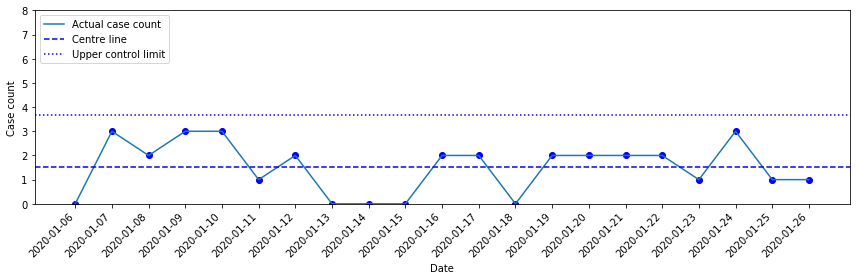

In [14]:
fig, ax = plt.subplots(1,1,figsize=(12,4))

plt.ylim(0,8)

x=df_control_chart['Date']
y=df_control_chart['Count']

sns.lineplot(x='Date', y='Count', 
             data=df_control_chart, label = 'Actual case count')

plt.axhline(y=mean, color='b', linestyle='--', label = 'Centre line')
plt.axhline(y=ucl, color='b', linestyle='dotted', label = 'Upper control limit')

threshold = ucl

# Add below threshold markers
below_threshold = y < threshold
plt.scatter(x[below_threshold], y[below_threshold], color='blue') 

# Add above threshold markers
above_threshold = np.logical_not(below_threshold)
plt.scatter(x[above_threshold], y[above_threshold], color='red') 

ax.set_ylabel('Case count')

plt.legend(loc='upper left')


fig.autofmt_xdate(rotation=45)
fig.tight_layout()

## Generate geospatial map

The lookback_days_map can be varied depending on how far back to look for the geospatial map. In this demo, it is set at 5 days.

In [15]:
lookback_days_map = 5
lookback_list_map = list(range(1, int(lookback_days_map) + 1))[::-1]

This generates a table of cases over the look back period.

In [16]:
df_hall_lookback = pd.DataFrame()

for i in lookback_list_map:
    df_hall_ytd = df_hall[df_hall['MockVisitDate'] == (pd.to_datetime('2020-01-27') - pd.DateOffset(i)).normalize()]
    
    df_hall_lookback = df_hall_lookback.append(df_hall_ytd)

This splits the location variable to row, room and bed.

In [20]:
def get_row(location):
    row = location[1:3]
    return row

def get_room(location):
    room = location[3:5]
    return room

def get_bed(location):
    bed = location[-1]
    return bed

df_hall_lookback['Row'] = df_hall_lookback['MockBed'].apply(get_row)
df_hall_lookback['Room'] = df_hall_lookback['MockBed'].apply(get_room)
df_hall_lookback['Bed'] = df_hall_lookback['MockBed'].apply(get_bed)

df_hall_lookback['Row'] = pd.to_numeric(df_hall_lookback['Row'])
df_hall_lookback['Room'] = pd.to_numeric(df_hall_lookback['Room'])
df_hall_lookback['Bed'] = pd.to_numeric(df_hall_lookback['Bed'])

This creates a dataframe which can be used to generate the geospatial map.

In [21]:
df_geobased_map = df_hall_lookback[['MockHall','MockVisitDate','MockName','MockID','MockBed','MockVisitDiagnosis','GE','Row','Room','Bed']]

This splits the dataframe into two halls, which can be plotted separtely later.

In [22]:
df_geobased_mapA = df_geobased_map[df_geobased_map['MockHall'] == 'A']
df_geobased_mapB = df_geobased_map[df_geobased_map['MockHall'] == 'B']

This generates the geospatial map using a scatter plot function. Each hall is plotted as a subplot. The blue triangles indicate positive GE cases, while the grey triangles indicate an non-GE occupant.

Text(0.5, 0.98, 'Map of residents who reported sick for GE between 2020-01-22 and 2020-01-26')

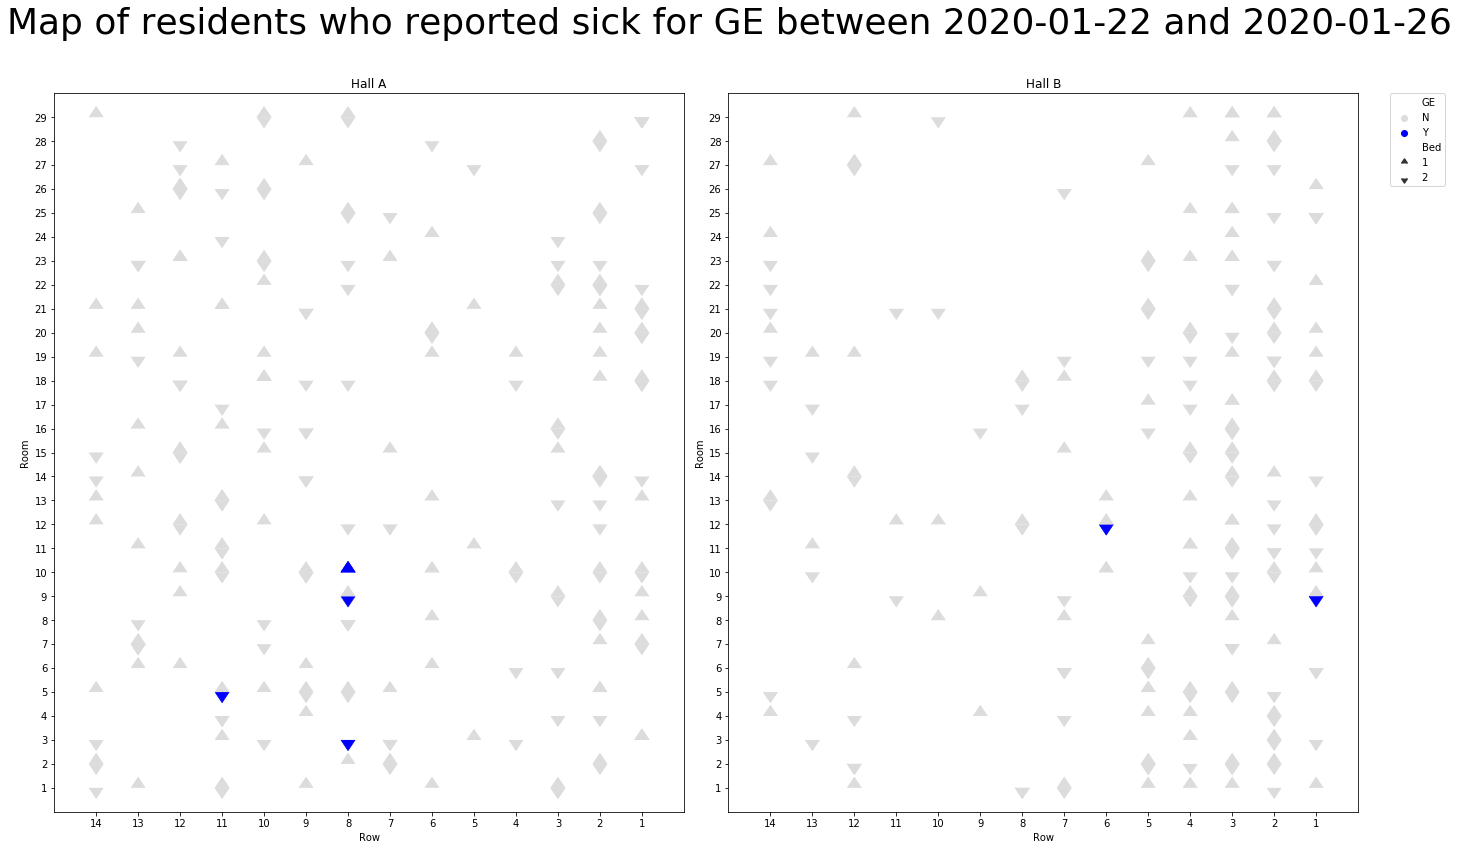

In [23]:
fig,axes = plt.subplots(1,2, figsize=(20,12))

axes[0].invert_xaxis()
axes[1].invert_xaxis()

axes[0].set_xticks(np.arange(1,15, 1.0))
axes[0].set_yticks(np.arange(1,30, 1.0))
axes[1].set_xticks(np.arange(1,15, 1.0))
axes[1].set_yticks(np.arange(1,30, 1.0))

axes[0].set(xlim=(15,0), ylim=(0,30))
axes[1].set(xlim=(15,0), ylim=(0,30))

sns.scatterplot(x = 'Row', 
                y = 'Room',
                data = df_geobased_mapA,
                style ='Bed',
                s = 200,
                markers = [10, 11],
                legend=False,
               ax=axes[0],
                hue = 'GE',
                palette=dict(Y="Blue", N='gainsboro')
               ).set_title("Hall A")

sns.scatterplot(x = 'Row', 
                y = 'Room',
                data = df_geobased_mapB,
                style ='Bed',
                s = 200,
                markers = [10, 11],
               legend = 'brief',
               ax=axes[1],
                hue = 'GE',
                palette=dict(Y="Blue", N='gainsboro')).set_title("Hall B")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.suptitle('Map of residents who reported sick for GE between {} and {}'.format(str(((pd.to_datetime('2020-01-27') - pd.DateOffset(lookback_days_map)).normalize()))[:10],str((pd.to_datetime('2020-01-27')- pd.DateOffset(1)))[0:10]), 
             size = 36)